In [1]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features_filename = '39-features-v2.xlsx'

In [3]:
df = pd.read_excel(features_filename, index_col=0)

# Histogram

In [4]:
mep_metric = 'mep_category_absolute'

In [5]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,1699.758956,389.247039,9.290681,-0.203200,795.413564,391.136163,0.976562,-0.260847,920.688314,205.866166
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,1350.207889,412.348892,11.048543,-0.074716,2749.205329,869.753544,15.625000,-0.341944,874.440057,279.965552
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,1504.189000,407.994715,2.129898,-0.179751,2413.468286,1359.271661,17.039183,-0.176331,822.499312,317.586076
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,722.309329,221.358686,18.581361,-0.500718,1147.498869,447.783394,1.953125,-0.117707,846.045450,335.391806
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1182.716816,7.812500,-0.102074,1469.422729,698.547856,1.161335,-0.206620,2639.615189,646.149552


In [11]:
channel = 'ltm1'

In [15]:
x = df['wavelet_' + channel + '_max_power_at_freq']
y = df['wavelet_' + channel + '_max_power_freq']
z = df[mep_metric]

In [19]:
print(x.shape)
print(y.shape)
print(z.shape)

(1400,)
(1400,)
(1400,)


In [56]:
import seaborn as sns

In [94]:
df2 = df
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group'] = df2['power_group'].astype(str)
df2 = df2.pivot_table(mep_metric, 'wavelet_' + channel + '_max_power_at_freq', 'power_group')

# z = df2.drop(df2.columns[len(df2.columns)-1], axis=1)
# z = z.drop(z.tail(1).index)

In [95]:
df2.head()

power_group,"(0.0, 141.414]","(10040.404, 10181.818]","(10888.889, 11030.303]","(1131.313, 1272.727]","(11737.374, 11878.788]","(11878.788, 12020.202]","(1272.727, 1414.141]","(12868.687, 13010.101]","(141.414, 282.828]","(1414.141, 1555.556]",...,"(707.071, 848.485]","(7070.707, 7212.121]","(7353.535, 7494.949]","(7494.949, 7636.364]","(7919.192, 8060.606]","(848.485, 989.899]","(8484.848, 8626.263]","(8626.263, 8767.677]","(989.899, 1131.313]",nan
wavelet_ltm1_max_power_at_freq,,,,,,,,,,,,,,,,,,,,,
2.129898,0.687500,NaN,NaN,1.181818,NaN,NaN,0.900000,2.0,0.703704,1.0,...,0.892857,1.0,NaN,1.0,1.0,1.090909,1.0,1.0,0.750000,1.5
2.322670,0.500000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,1.000000,1.0,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
2.532890,0.250000,NaN,1.0,1.000000,NaN,NaN,0.000000,NaN,0.692308,1.0,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN
2.762136,0.200000,NaN,NaN,1.000000,NaN,NaN,0.666667,NaN,1.230769,2.0,...,0.857143,NaN,NaN,NaN,NaN,1.333333,NaN,NaN,0.714286,NaN
3.012131,0.285714,NaN,NaN,0.750000,NaN,1.0,1.200000,NaN,0.833333,1.0,...,1.000000,NaN,1.0,NaN,NaN,0.833333,NaN,NaN,1.000000,2.0


In [96]:
df2.shape

(28, 56)

<IPython.core.display.Javascript object>


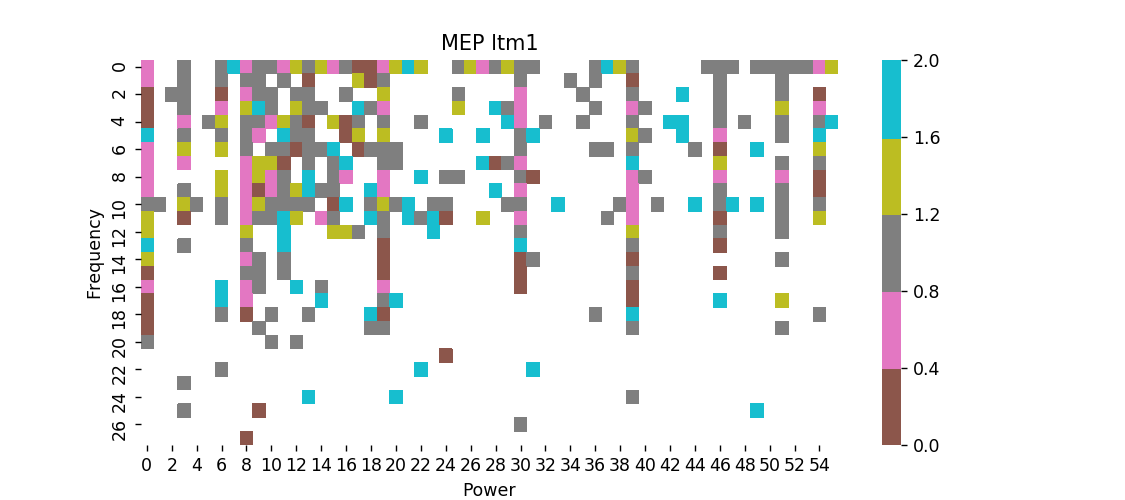

In [100]:
plt.figure(figsize=(9,4))
ax = sns.heatmap(df2.values, cmap='tab10', robust=True, center=0)
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
ax.set_title('MEP ' + channel)
plt.show()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


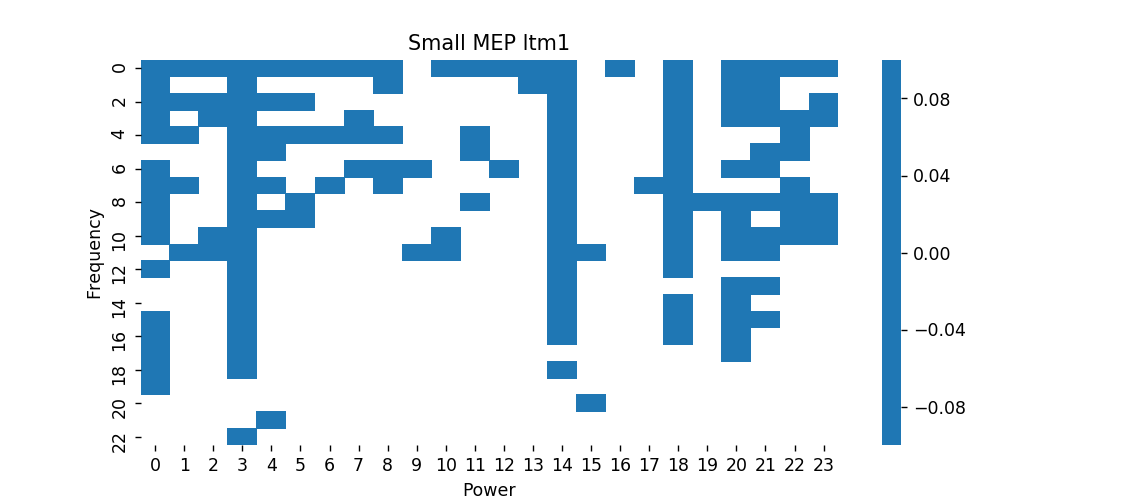

In [101]:
df2 = df[df[mep_metric] == 0]
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group'] = df2['power_group'].astype(str)
df2 = df2.pivot_table(mep_metric, 'wavelet_' + channel + '_max_power_at_freq', 'power_group')
plt.figure(figsize=(9,4))
ax = sns.heatmap(df2.values, cmap='tab10', robust=True, center=0)
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
ax.set_title('Small MEP ' + channel)
plt.show()

In [117]:
def plot_heatmap(df2, title):
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group'] = df2['power_group'].astype(str)
    df2 = df2.groupby(['power_group', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.pivot_table(mep_metric, 'power_group', 'wavelet_' + channel + '_max_power_at_freq')
    plt.figure(figsize=(9,6))
    ax = sns.heatmap(df2.values, cmap='viridis', robust=True)
    ax.set_xlabel('Power')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


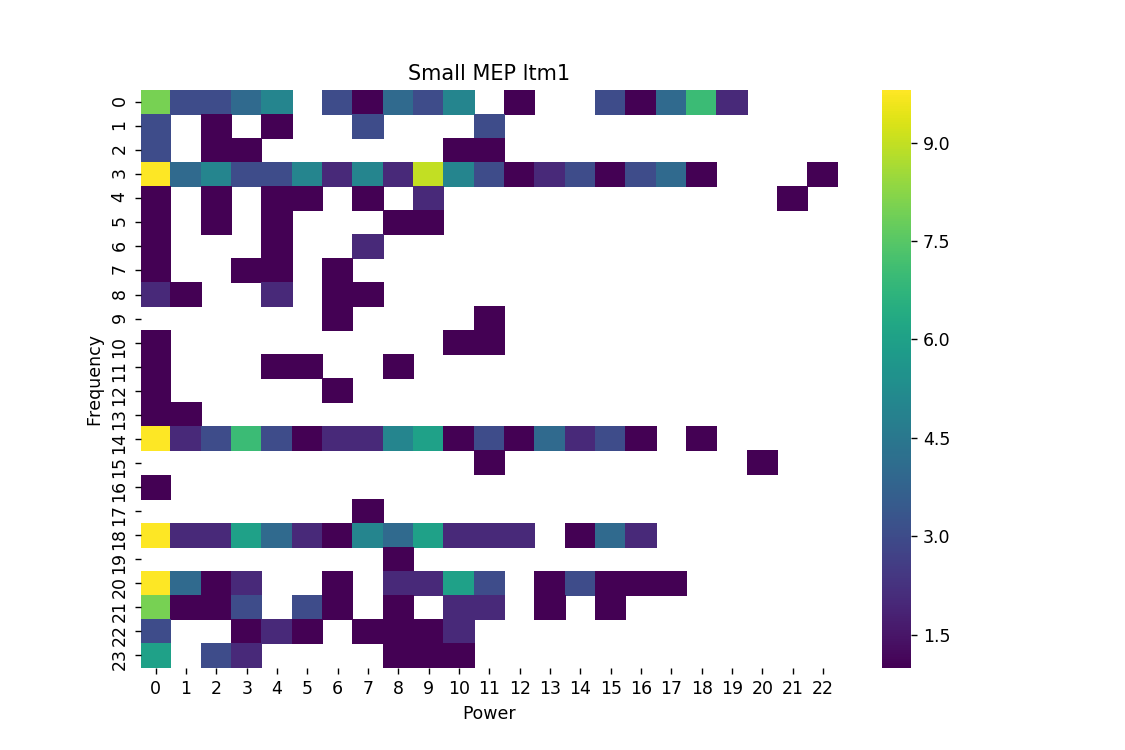

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


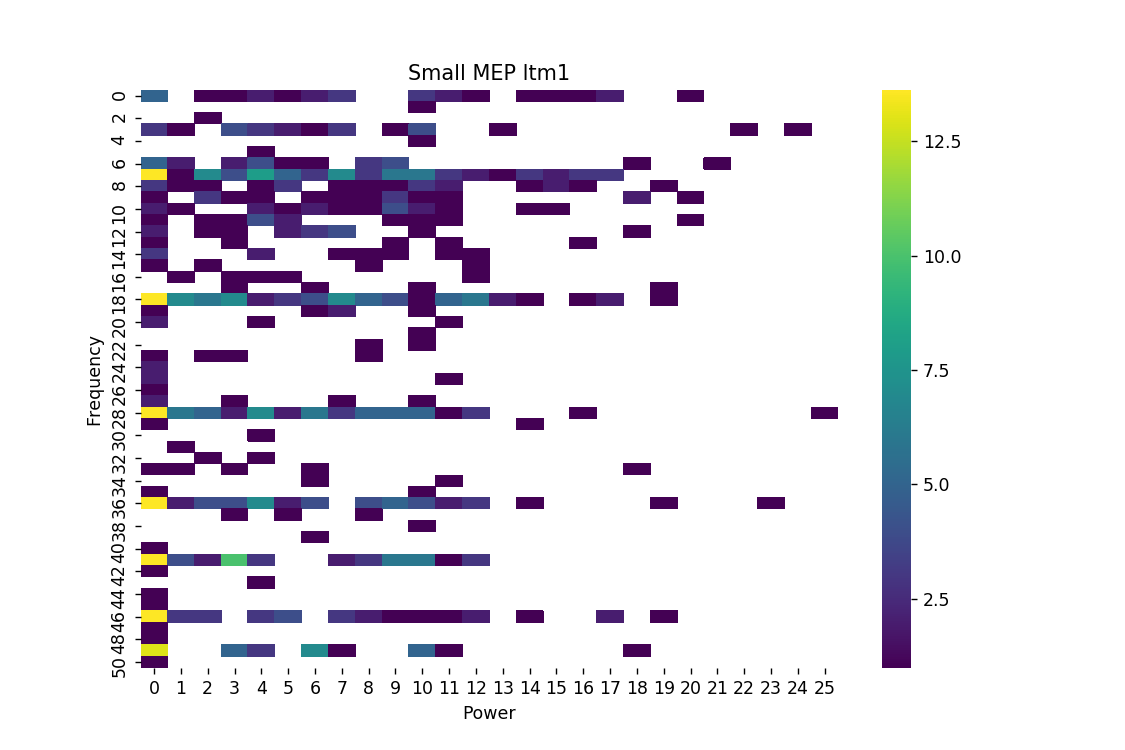

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


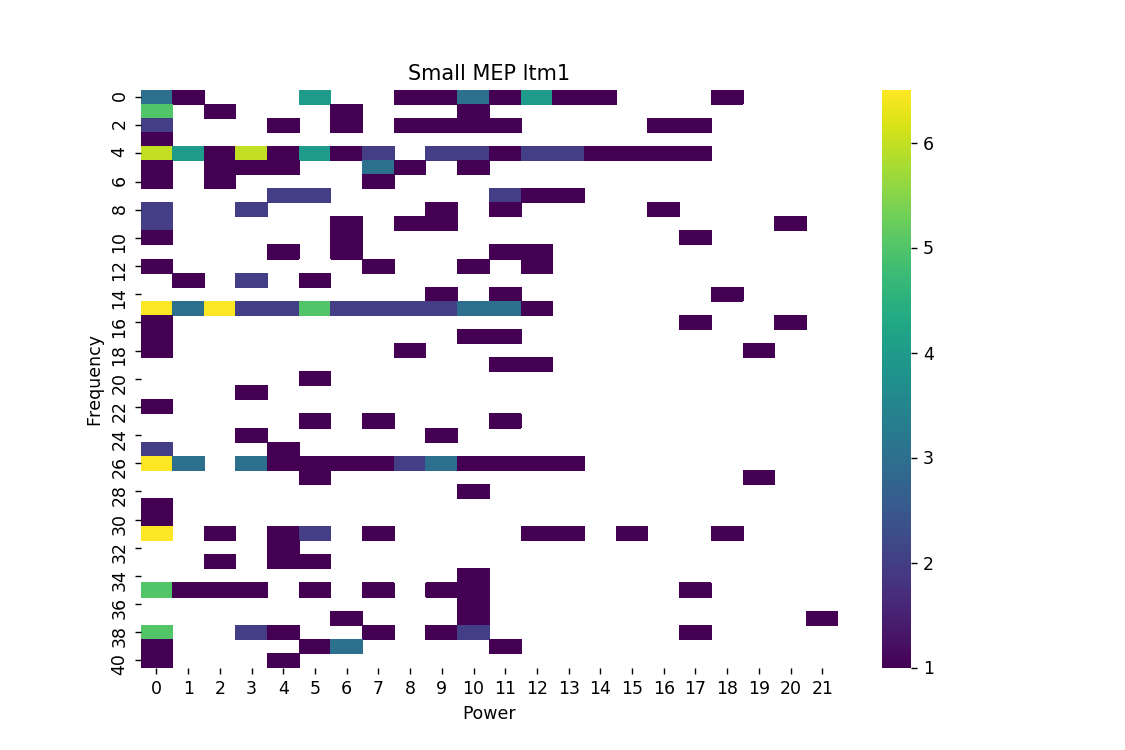

In [118]:
plot_heatmap(df[df[mep_metric] == 0], 'Small MEP ' + channel)
plot_heatmap(df[df[mep_metric] == 1], 'Medium MEP ' + channel)
plot_heatmap(df[df[mep_metric] == 2], 'Large MEP ' + channel)
